# Combined EDA
### on mask wearing, social distancing, mask wearing requirements and covid cases

In [1]:
import sys
sys.path.insert(1, '/Users/jakoliendenhollander/capstone/capstone')
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import functions.functions_data
import functions.functions_corona_stats
import functions.functions_mask_req
import functions.functions_HDI
import functions.functions_mask_wearing
import functions.functions_get_group

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None) # To display all columns
plt.style.use('seaborn-talk')
sns.set_style("whitegrid")
mono_palette = ["steelblue"]
heatmap_palette = sns.diverging_palette(240, 10, n=9)
gender_palette = ["indianred", "steelblue"]

## Read in data

In [2]:
# Reading in survey data from csv into a dictionary of dataframes.
dfs_country = functions.functions_data.get_data("/Users/jakoliendenhollander/capstone/capstone/data/CMU_Global_data/Full_Survey_Data/country/smooth/", "country")

# Concatenating individuals dataframes from the dictionary into one dataframe for regions.
survey_data = pd.concat(dfs_country, ignore_index=True)

Read in data completed.


In [3]:
# Corona stats
covid_cases = pd.read_csv("/Users/jakoliendenhollander/capstone/capstone/data/Corona_stats/owid-covid-data.csv")
merged_1 = functions.functions_corona_stats.merge_corona_stats(survey_data,covid_cases)

# Mask wearing requirements
mask_wearing_requirements = pd.read_csv("/Users/jakoliendenhollander/capstone/capstone/data/data-nbhtq.csv")
merged_2 = functions.functions_mask_req.merge_mask_requirements(merged_1,mask_wearing_requirements)

# HDI
dict_hdi, dict_hdi_levels = functions.functions_HDI.get_hdi("/Users/jakoliendenhollander/capstone/capstone/data/","hdro_statistical_data_tables_1_15_d1_d5.xlsx")
merged_3 = functions.functions_HDI.create_hdi_columns(merged_2, dict_hdi, dict_hdi_levels)

Merging corona stats completed.
Merging mask wearing requirements completed.
Creating dictionaries for hdi and hdi-levels completed.
Creating hdi list completed.
Creating hdi-level list completed.


In [4]:
merged_3

,Unnamed: 0,country_agg,gender,age_bucket,date,rolling_total_responses,weight_sums,smoothed_pct_cli,smoothed_pct_ili,smoothed_pct_fever,smoothed_pct_cough,smoothed_pct_difficulty_breathing,smoothed_pct_fatigue,smoothed_pct_stuffy_runny_nose,smoothed_pct_aches_muscle_pain,smoothed_pct_sore_throat,smoothed_pct_chest_pain,smoothed_pct_nausea,smoothed_pct_anosmia_ageusia,smoothed_pct_eye_pain,smoothed_pct_headache,smoothed_pct_cmnty_sick,smoothed_pct_ever_tested,smoothed_pct_tested_recently,smoothed_pct_worked_outside_home,smoothed_pct_grocery_outside_home,smoothed_pct_ate_outside_home,smoothed_pct_spent_time_with_non_hh,smoothed_pct_attended_public_event,smoothed_pct_used_public_transit,smoothed_pct_direct_contact_with_non_hh,smoothed_pct_wear_mask_all_time,smoothed_pct_wear_mask_most_time,smoothed_pct_wear_mask_half_time,smoothed_pct_wear_mask_some_time,smoothed_pct_wear_mask_none_time,smoothed_pct_no_public,smoothed_pct_feel_nervous_all_time,smoothed_pct_feel_nervous_most_time,smoothed_pct_feel_nervous_some_time,smoothed_pct_feel_nervous_little_time,smoothed_pct_feel_nervous_none_time,smoothed_pct_feel_depressed_all_time,smoothed_pct_feel_depressed_most_time,smoothed_pct_feel_depressed_some_time,smoothed_pct_feel_depressed_little_time,smoothed_pct_feel_depressed_none_time,smoothed_pct_worried_ill_covid19_very,smoothed_pct_worried_ill_covid19_somewhat,smoothed_pct_worried_ill_covid19_notTooWorried,smoothed_pct_worried_ill_covid19_notWorried,smoothed_pct_enough_toEat_very_worried,smoothed_pct_enough_toEat_somewhat_worried,smoothed_pct_enough_toEat_notToo_worried,smoothed_pct_enough_toEat_not_worried,smoothed_pct_cli_weighted,smoothed_pct_ili_weighted,smoothed_pct_fever_weighted,smoothed_pct_cough_weighted,smoothed_pct_difficulty_breathing_weighted,smoothed_pct_fatigue_weighted,smoothed_pct_stuffy_runny_nose_weighted,smoothed_pct_aches_muscle_pain_weighted,smoothed_pct_sore_throat_weighted,smoothed_pct_chest_pain_weighted,smoothed_pct_nausea_weighted,smoothed_pct_anosmia_ageusia_weighted,smoothed_pct_eye_pain_weighted,smoothed_pct_headache_weighted,smoothed_pct_cmnty_sick_weighted,smoothed_pct_ever_tested_weighted,smoothed_pct_tested_recently_weighted,smoothed_pct_worked_outside_home_weighted,smoothed_pct_grocery_outside_home_weighted,smoothed_pct_ate_outside_home_weighted,smoothed_pct_spent_time_with_non_hh_weighted,smoothed_pct_attended_public_event_weighted,smoothed_pct_used_public_transit_weighted,smoothed_pct_direct_contact_with_non_hh_weighted,smoothed_pct_wear_mask_all_time_weighted,smoothed_pct_wear_mask_most_time_weighted,smoothed_pct_wear_mask_half_time_weighted,smoothed_pct_wear_mask_some_time_weighted,smoothed_pct_wear_mask_none_time_weighted,smoothed_pct_no_public_weighted,smoothed_pct_feel_nervous_all_time_weighted,smoothed_pct_feel_nervous_most_time_weighted,smoothed_pct_feel_nervous_some_time_weighted,smoothed_pct_feel_nervous_little_time_weighted,smoothed_pct_feel_nervous_none_time_weighted,smoothed_pct_feel_depressed_all_time_weighted,smoothed_pct_feel_depressed_most_time_weighted,smoothed_pct_feel_depressed_some_time_weighted,smoothed_pct_feel_depressed_little_time_weighted,smoothed_pct_feel_depressed_none_time_weighted,smoothed_pct_worried_ill_covid19_very_weighted,smoothed_pct_worried_ill_covid19_somewhat_weighted,smoothed_pct_worried_ill_covid19_notTooWorried_weighted,smoothed_pct_worried_ill_covid19_notWorried_weighted,smoothed_pct_enough_toEat_very_worried_weighted,smoothed_pct_enough_toEat_somewhat_worried_weighted,smoothed_pct_enough_toEat_notToo_worried_weighted,smoothed_pct_enough_toEat_not_worried_weighted,smoothed_pct_chills,smoothed_pct_chills_weighted,smoothedpct_wear_mask_all_time_weighted,smoothed_pct_finances_very_worried,smoothed_pct_finances_somewhat_worried,smoothed_pct_finances_notToo_worried,smoothed_pct_finances_not_worried,smoothed_pct_finances_very_worried_weighted,smoothed_pct_finances_somewhat_worried_weighted,smoothed_pct_finances_notToo_worried_weighted,smoothed_pct_finances_not_worri

## Data cleaning

In [5]:
# Change object into datetime object and create month column
df_month = functions.functions_data.insert_month(merged_3)

# Deal with NaN's in the wearing mask all the time column
df_complete = functions.functions_mask_wearing.deal_with_NaNs_masks(df_month)

# Delete instances of 'other' gender
df_gender = df_complete[df_complete['gender']!='other']

Created month column.
NaNs before update: 157549
NaNs after update: 0
Updated.


## Feature engineering

In [6]:
df_combined = functions.functions_mask_req.add_requirement_by_date(df_gender)

Feature engineering completed.


## Wearing masks and social distancing

In [7]:
df_dist_masks = df_combined[["new_cases_smoothed_per_million","new_deaths_smoothed_per_million","smoothed_pct_worked_outside_home_weighted","smoothed_pct_grocery_outside_home_weighted",
                           "smoothed_pct_ate_outside_home_weighted","smoothed_pct_spent_time_with_non_hh_weighted",
                           "smoothed_pct_attended_public_event_weighted","smoothed_pct_used_public_transit_weighted",
                           "smoothed_pct_direct_contact_with_non_hh_weighted","smoothed_pct_no_public_weighted"]]

mask_names = df_combined.columns[(df_combined.columns.str.contains("mask") & (df_combined.columns.str.contains("weighted")))]

for i in mask_names:
    df_dist_masks[str(i)] = df_combined[str(i)]

In [8]:
to_normalize = df_dist_masks.columns[(df_dist_masks.columns.str.contains("weighted"))]

for i in to_normalize:
    df_dist_masks[str(i)] = df_dist_masks[str(i)]/100

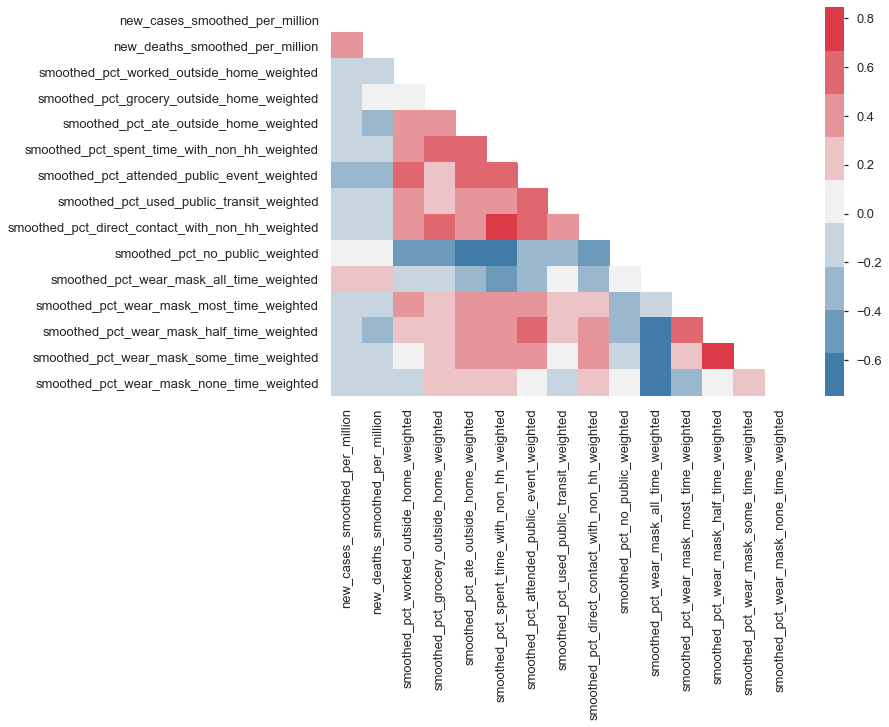

In [9]:
corr_dist_masks_world = df_dist_masks.corr()
mask_world = np.triu(np.ones_like(corr_dist_masks_world, dtype=bool))
sns.heatmap(corr_dist_masks_world, mask=mask_world, cmap=heatmap_palette);

In [10]:
df_dist_masks['date'] = df_combined['date']

In [11]:
df_mask = df_dist_masks.groupby('date')[['smoothed_pct_wear_mask_all_time_weighted',
                                                 'smoothed_pct_wear_mask_most_time_weighted',
                                                 'smoothed_pct_wear_mask_half_time_weighted',
                                                 'smoothed_pct_wear_mask_some_time_weighted',
                                                 'smoothed_pct_wear_mask_none_time_weighted',
                                                 ]].mean()
df_mask = df_mask.stack().reset_index()

In [12]:
df_dist = df_dist_masks.groupby('date')[['smoothed_pct_worked_outside_home_weighted',
                                        'smoothed_pct_grocery_outside_home_weighted',
                                        'smoothed_pct_ate_outside_home_weighted',
                                        'smoothed_pct_spent_time_with_non_hh_weighted',
                                        'smoothed_pct_attended_public_event_weighted',
                                        'smoothed_pct_used_public_transit_weighted',
                                        'smoothed_pct_direct_contact_with_non_hh_weighted',
                                        'smoothed_pct_no_public_weighted']].mean()
df_dist = df_dist.stack().reset_index()

In [13]:
df_cases = df_dist_masks.groupby('date')[['new_cases_smoothed_per_million','new_deaths_smoothed_per_million']].mean()
df_cases = df_cases.stack().reset_index()

In [14]:
df_mask = df_mask.rename(columns={"level_1": "data_mask", 0: "amount"})
df_dist = df_dist.rename(columns={"level_1": "data_dist", 0: "amount"})
df_cases = df_cases.rename(columns={"level_1": "data_cases", 0: "amount"})

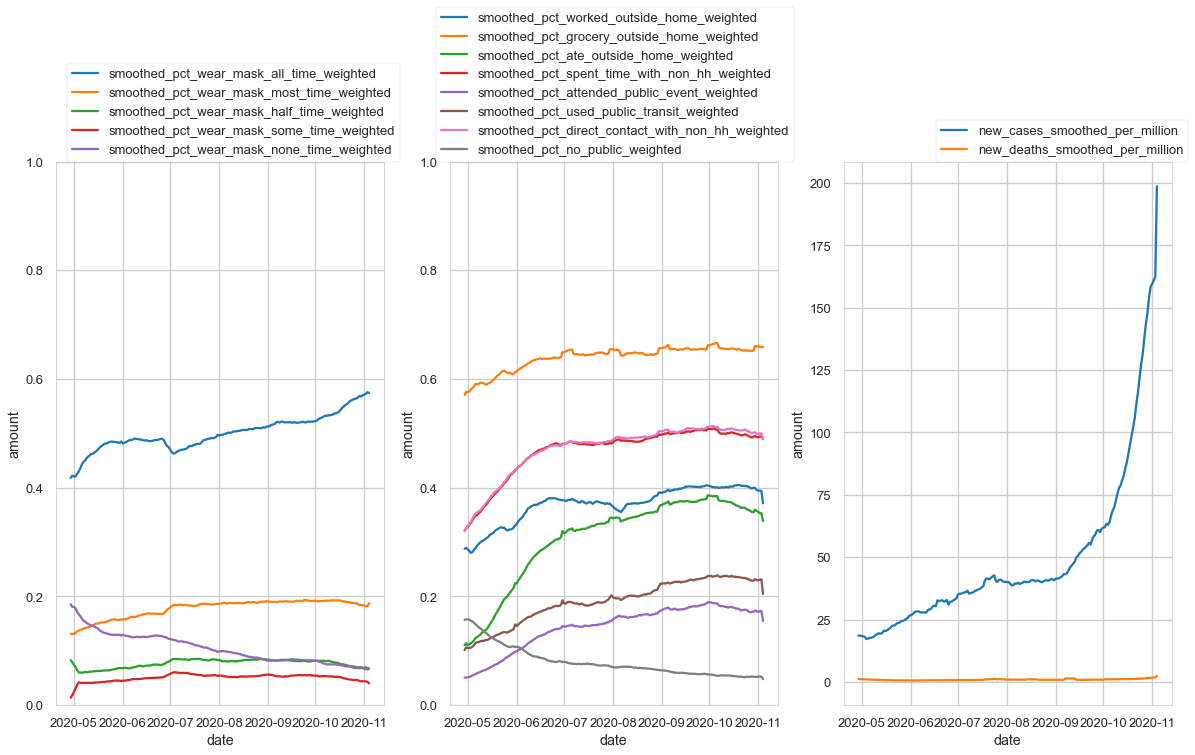

In [15]:
f, axes = plt.subplots(1,3, figsize=(20,10))
g1 = sns.lineplot(data=df_mask, x='date', y='amount', hue='data_mask', ax=axes[0]);
g1.set_ylim(ymin=0,ymax=1);
g1.legend().set_title('');
g1.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);

g2 = sns.lineplot(data=df_dist, x='date', y='amount', hue='data_dist', ax=axes[1]);
g2.set_ylim(ymin=0,ymax=1);
g2.legend().set_title('');
g2.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);

g3 = sns.lineplot(data=df_cases, x='date', y='amount', hue='data_cases', ax=axes[2]);
g3.legend().set_title('');
g3.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);

## Mask wearing requirements and mask wearing survey data

In [16]:
df_masks_req_time = df_combined[["cur_mask_recommended","cur_mask_required_full_country","cur_mask_not_required","cur_mask_not_required_recommended",
                          "cur_mask_not_required_universal","cur_mask_required_part_country","cur_mask_everywhere_in_public",
                          "cur_mask_public_indoors","cur_mask_public_transport"]]
mask_names = df_combined.columns[(df_combined.columns.str.contains("mask") & (df_combined.columns.str.contains("weighted")))]

for i in mask_names:
    df_masks_req_time[str(i)] = df_combined[str(i)]

In [17]:
to_normalize = df_masks_req_time.columns[(df_masks_req_time.columns.str.contains("weighted"))]

for i in to_normalize:
    df_masks_req_time[str(i)] = df_masks_req_time[str(i)]/100

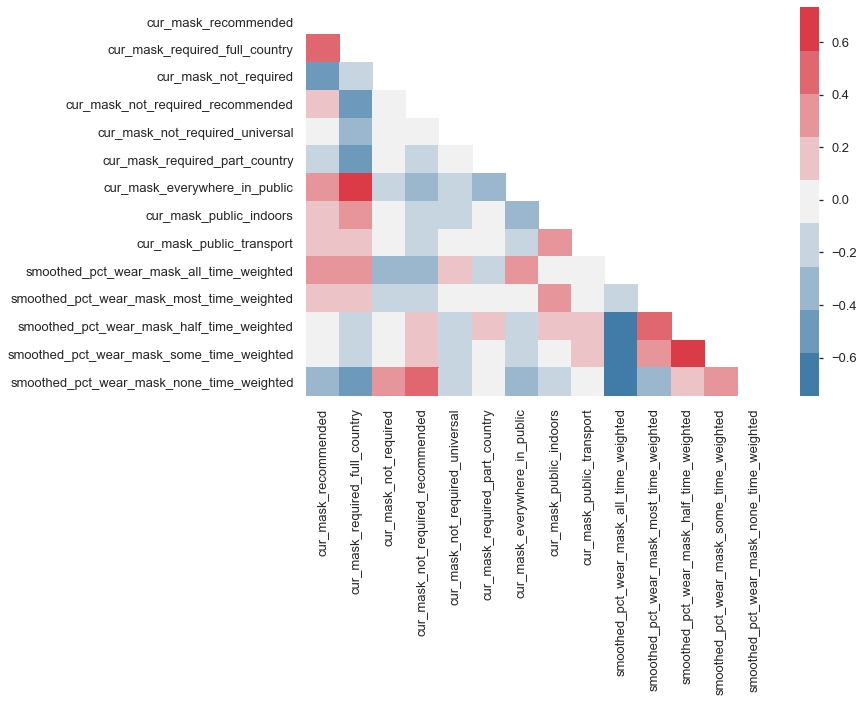

In [18]:
corr_masks_req_world = df_masks_req_time.corr()
mask_req_world = np.triu(np.ones_like(corr_masks_req_world, dtype=bool))
sns.heatmap(corr_masks_req_world, mask=mask_req_world, cmap=heatmap_palette);

In [20]:
df_masks_req_time['date'] = df_combined['date']
df_masks_req_time = df_masks_req_time.groupby("date")[["cur_mask_recommended","cur_mask_required_full_country",
                                            "cur_mask_not_required","cur_mask_not_required_recommended",
                                            "cur_mask_not_required_universal","cur_mask_required_part_country",
                                            "cur_mask_everywhere_in_public","cur_mask_public_indoors",
                                            "cur_mask_public_transport"]].mean()
df_masks_req_time = df_masks_req_time.stack().reset_index()

In [21]:
df_masks_req_time = df_masks_req_time.rename(columns={"level_1": "data_requirements", 0: "amount"})

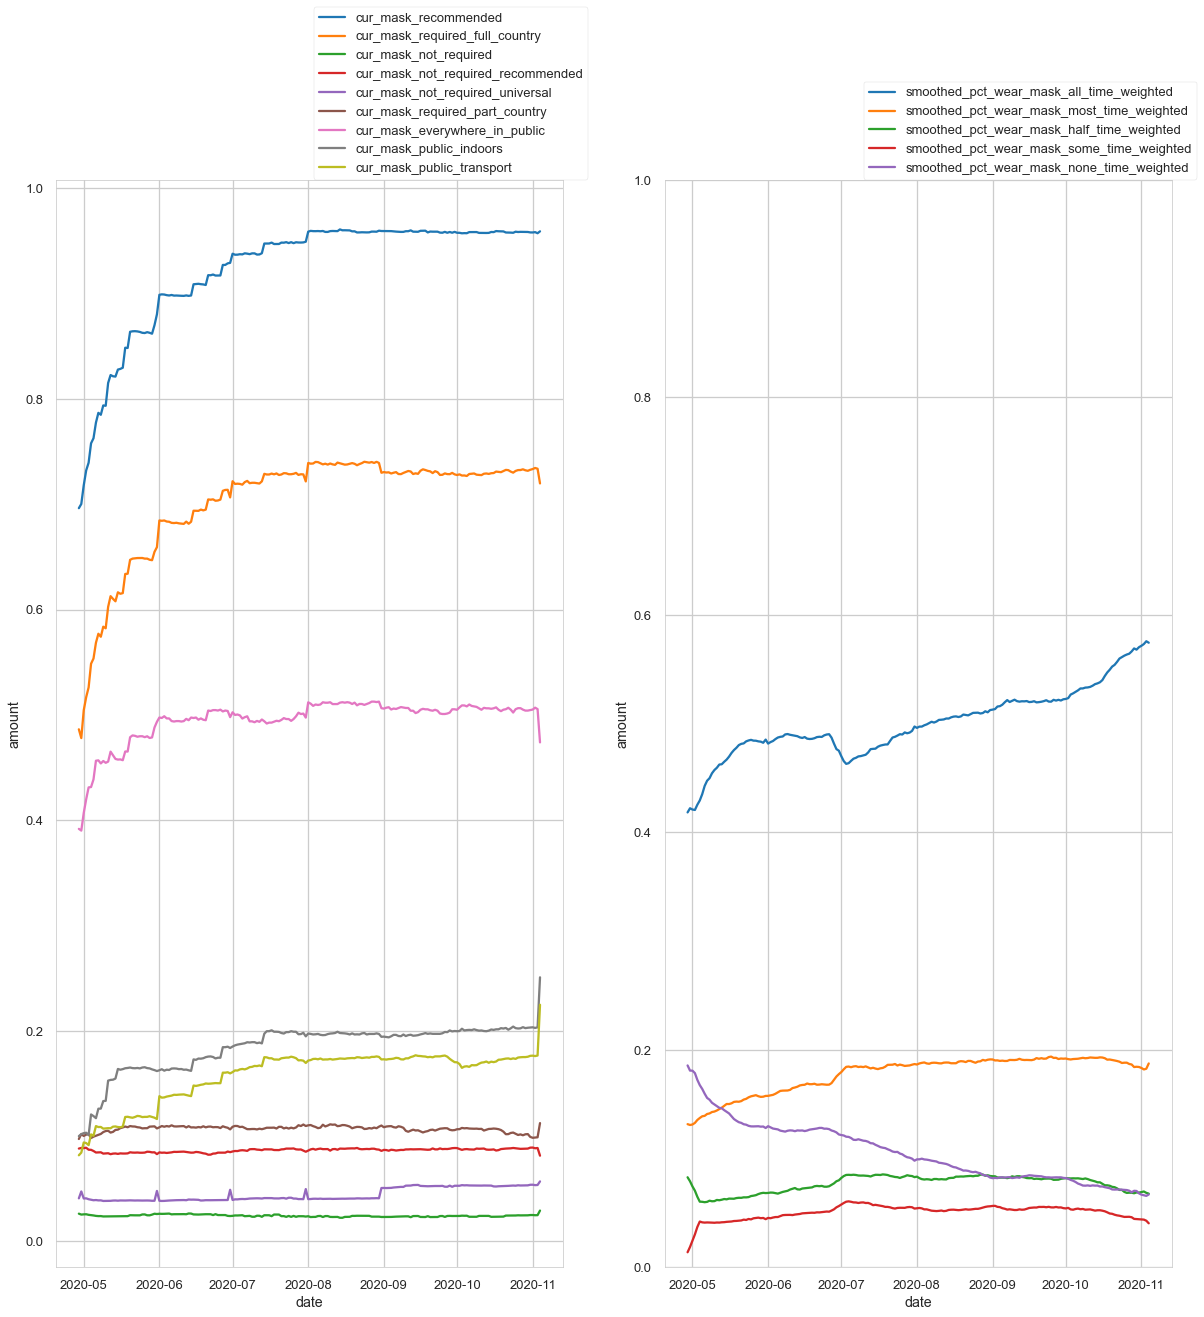

In [22]:
f, axes = plt.subplots(1,2, figsize=(20,20))

g12 = sns.lineplot(data=df_masks_req_time, x='date', y='amount', hue='data_requirements', ax=axes[0]);
g12.legend().set_title('');
g12.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);

g13 = sns.lineplot(data=df_mask, x='date', y='amount', hue='data_mask', ax=axes[1]);
g13.set_ylim(ymin=0,ymax=1);
g13.legend().set_title('');
g13.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);

In [23]:
df_masks_req = df_combined[["mask_recommended","mask_required_full_country","mask_not_required","mask_not_required_recommended",
                          "mask_not_required_universal","mask_required_part_country","mask_everywhere_in_public",
                          "mask_public_indoors","mask_public_transport"]]
mask_names = df_combined.columns[(df_combined.columns.str.contains("mask") & (df_combined.columns.str.contains("weighted")))]

for i in mask_names:
    df_masks_req[str(i)] = df_combined[str(i)]

In [24]:
to_normalize = df_masks_req.columns[(df_masks_req.columns.str.contains("weighted"))]

for i in to_normalize:
    df_masks_req[str(i)] = df_masks_req[str(i)]/100

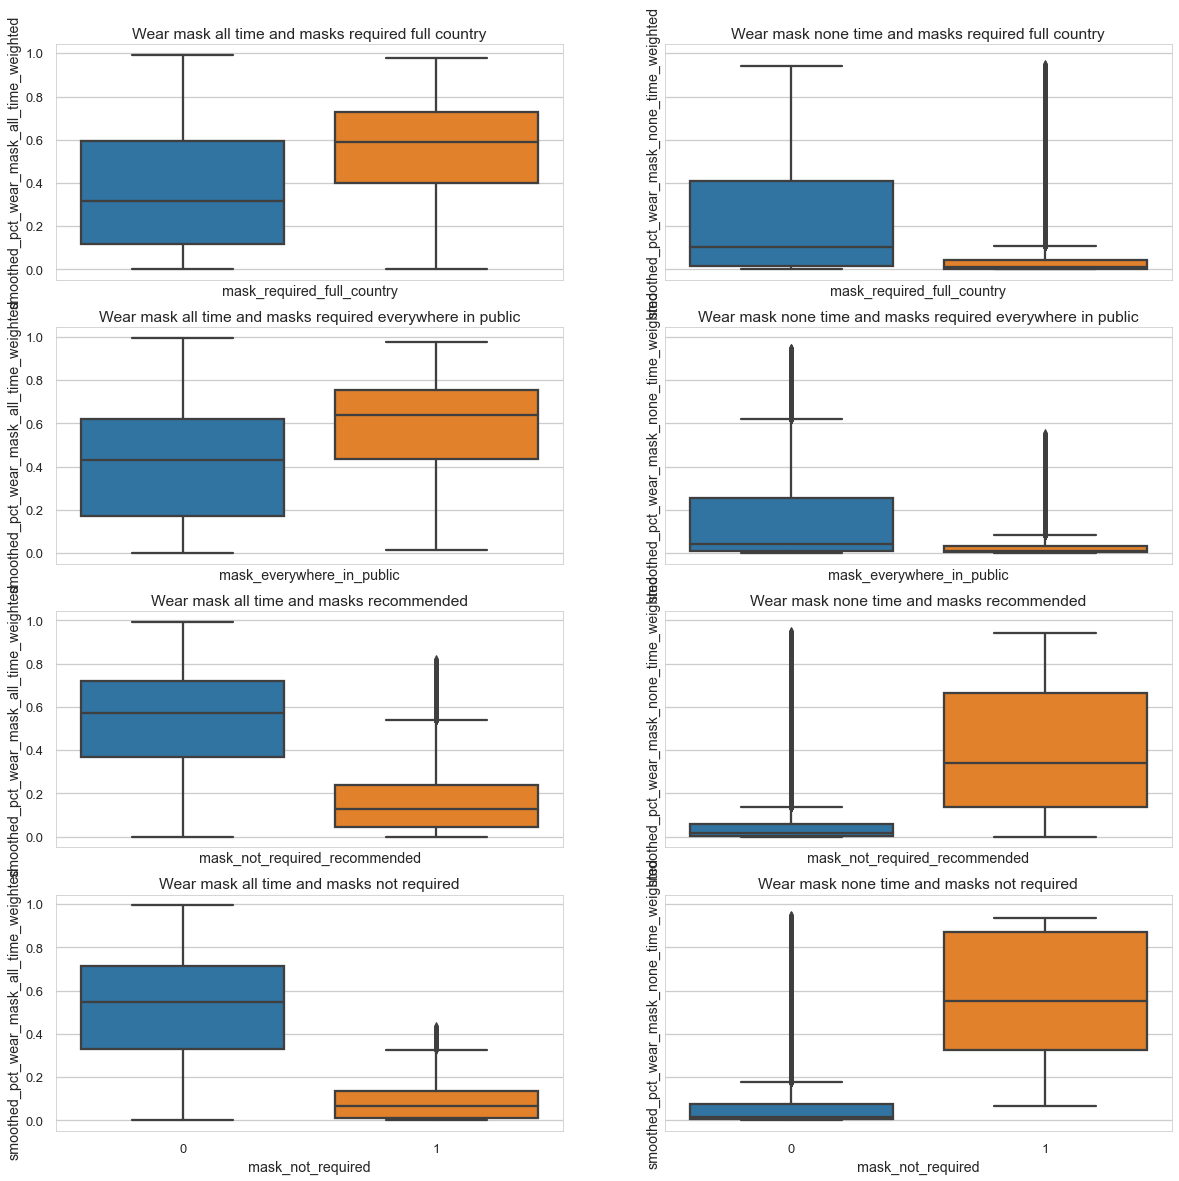

In [25]:
f, axes = plt.subplots(4,2, figsize=(20,20), sharex=True, sharey=True)

g1a=sns.boxplot(x="mask_required_full_country", y="smoothed_pct_wear_mask_all_time_weighted", data=df_masks_req, ax=axes[0][0]);
g1a.set_title('Wear mask all time and masks required full country');
g1b=sns.boxplot(x="mask_required_full_country", y="smoothed_pct_wear_mask_none_time_weighted", data=df_masks_req, ax=axes[0][1]);
g1b.set_title('Wear mask none time and masks required full country');

g2a=sns.boxplot(x="mask_everywhere_in_public", y="smoothed_pct_wear_mask_all_time_weighted", data=df_masks_req, ax=axes[1][0]);
g2a.set_title('Wear mask all time and masks required everywhere in public');
g2b=sns.boxplot(x="mask_everywhere_in_public", y="smoothed_pct_wear_mask_none_time_weighted", data=df_masks_req, ax=axes[1][1]);
g2b.set_title('Wear mask none time and masks required everywhere in public');

g3a=sns.boxplot(x="mask_not_required_recommended", y="smoothed_pct_wear_mask_all_time_weighted", data=df_masks_req, ax=axes[2][0]);
g3a.set_title('Wear mask all time and masks recommended');
g3b=sns.boxplot(x="mask_not_required_recommended", y="smoothed_pct_wear_mask_none_time_weighted", data=df_masks_req, ax=axes[2][1]);
g3b.set_title('Wear mask none time and masks recommended');


g4a=sns.boxplot(x="mask_not_required", y="smoothed_pct_wear_mask_all_time_weighted", data=df_masks_req, ax=axes[3][0]);
g4a.set_title('Wear mask all time and masks not required');
g4b=sns.boxplot(x="mask_not_required", y="smoothed_pct_wear_mask_none_time_weighted", data=df_masks_req, ax=axes[3][1]);
g4b.set_title('Wear mask none time and masks not required');

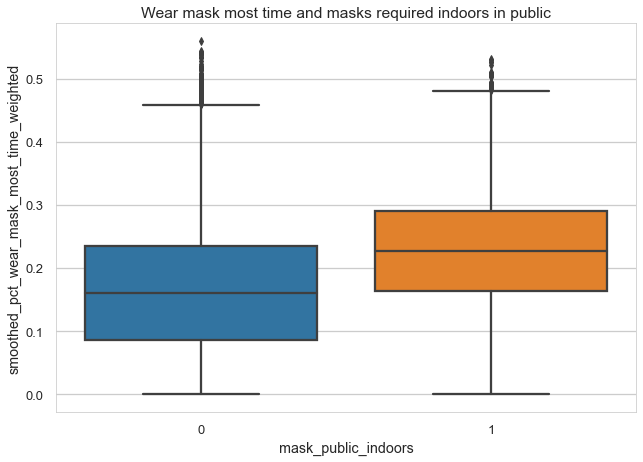

In [26]:
g5=sns.boxplot(x="mask_public_indoors", y="smoothed_pct_wear_mask_most_time_weighted", data=df_masks_req);
g5.set_title('Wear mask most time and masks required indoors in public');

## Mask wearing requirements and HDI

In [27]:
df_masks_req_hdi = df_combined[["mask_recommended","mask_required_full_country","mask_not_required","mask_not_required_recommended",
                          "mask_not_required_universal","mask_required_part_country","mask_everywhere_in_public",
                          "mask_public_indoors","mask_public_transport","hdi","hdi_level"]]

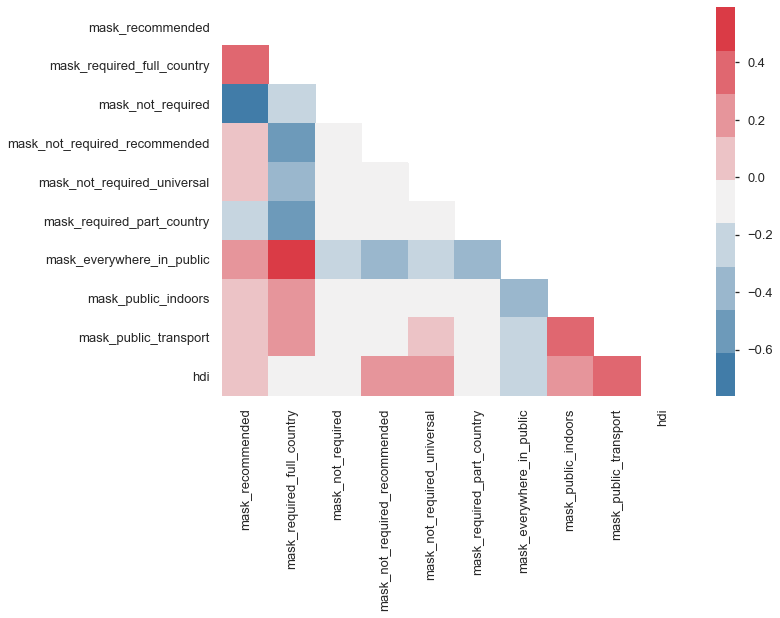

In [28]:
corr_masks_req_hdi_world = df_masks_req_hdi.corr()
mask_req_hdi_world = np.triu(np.ones_like(corr_masks_req_hdi_world, dtype=bool))
sns.heatmap(corr_masks_req_hdi_world, mask=mask_req_hdi_world, cmap=heatmap_palette);

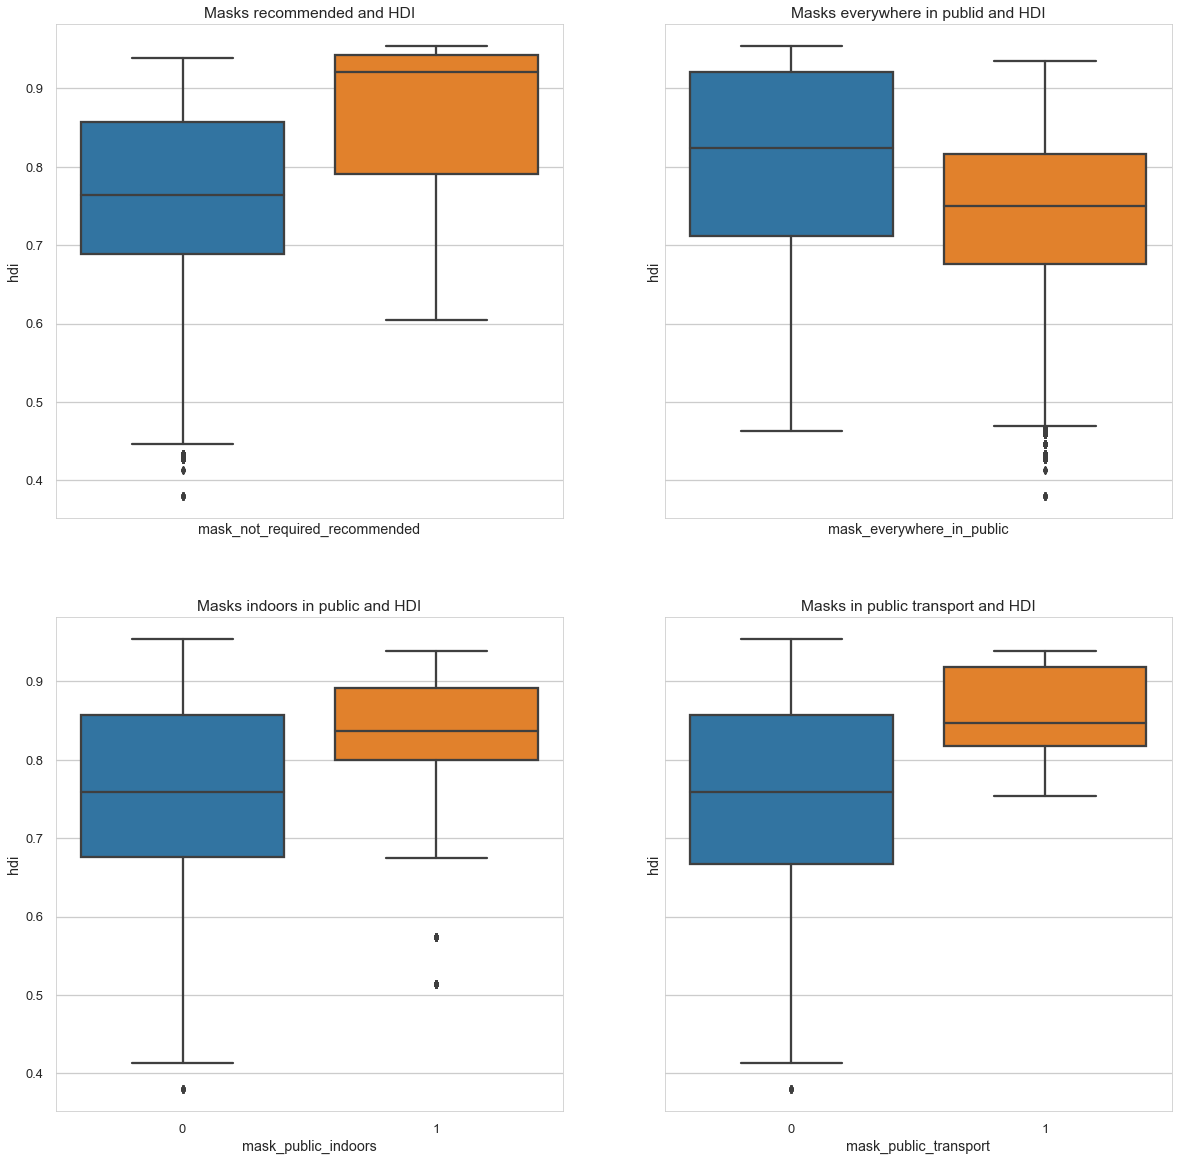

In [29]:
f, axes = plt.subplots(2,2, figsize=(20,20), sharex=True, sharey=True)

g7=sns.boxplot(x="mask_not_required_recommended", y="hdi", data=df_masks_req_hdi, ax=axes[0][0]);
g7.set_title('Masks recommended and HDI');
g8=sns.boxplot(x="mask_everywhere_in_public", y="hdi", data=df_masks_req_hdi, ax=axes[0][1]);
g8.set_title('Masks everywhere in publid and HDI');
g9=sns.boxplot(x="mask_public_indoors", y="hdi", data=df_masks_req_hdi, ax=axes[1][0]);
g9.set_title('Masks indoors in public and HDI');
g10=sns.boxplot(x="mask_public_transport", y="hdi", data=df_masks_req_hdi, ax=axes[1][1]);
g10.set_title('Masks in public transport and HDI');

## Mask wearing requirements and total covid cases

In [33]:
df_all_cases = df_combined[["mask_recommended","mask_required_full_country","mask_not_required","mask_not_required_recommended",
                          "mask_not_required_universal","mask_required_part_country","mask_everywhere_in_public",
                          "mask_public_indoors","mask_public_transport","new_cases_smoothed_per_million","new_deaths_smoothed_per_million",
                            "total_cases_per_million","total_deaths_per_million"]]

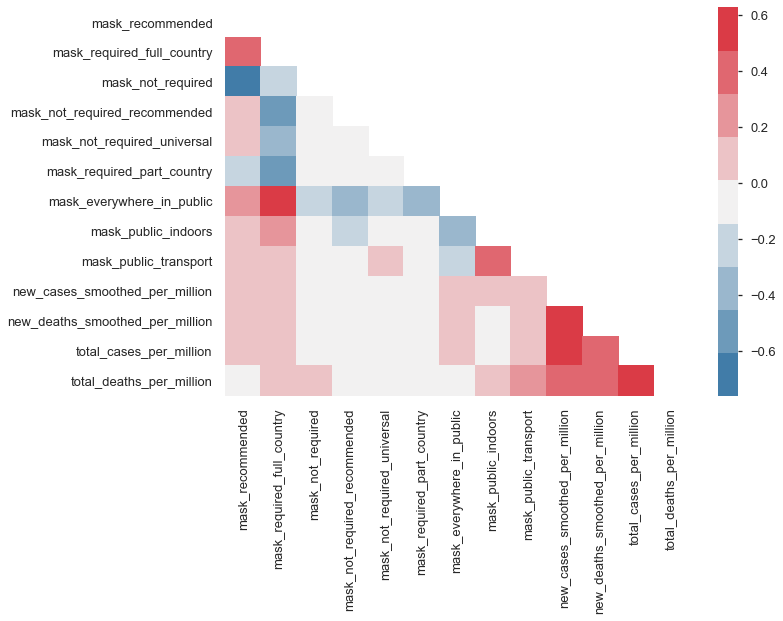

In [34]:
corr_masks_req_cases_world = df_all_cases.corr()
mask_req_cases_world = np.triu(np.ones_like(corr_masks_req_cases_world, dtype=bool))
sns.heatmap(corr_masks_req_cases_world, mask=mask_req_cases_world, cmap=heatmap_palette);

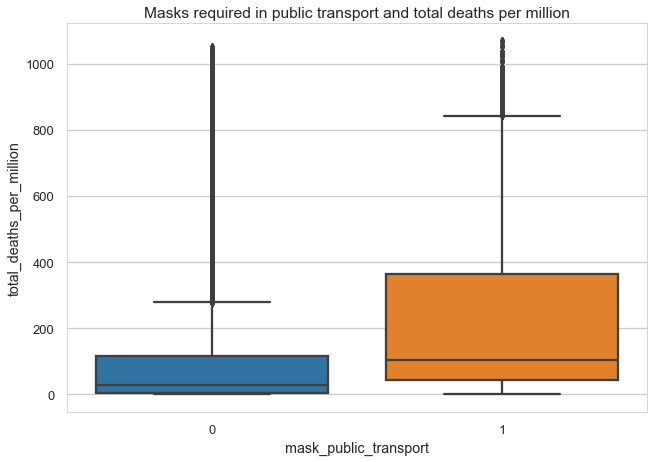

In [35]:
g11=sns.boxplot(x="mask_public_transport", y="total_deaths_per_million", data=df_all_cases);
g11.set_title('Masks required in public transport and total deaths per million');

In [36]:
df_all_cases['date'] = df_combined['date']
df_total_cases = df_all_cases.groupby('date')[['total_cases_per_million','total_deaths_per_million']].mean()
df_total_cases = df_total_cases.stack().reset_index()

In [39]:
df_total_cases = df_total_cases.rename(columns={"level_1": "data_cases", 0: "amount"})

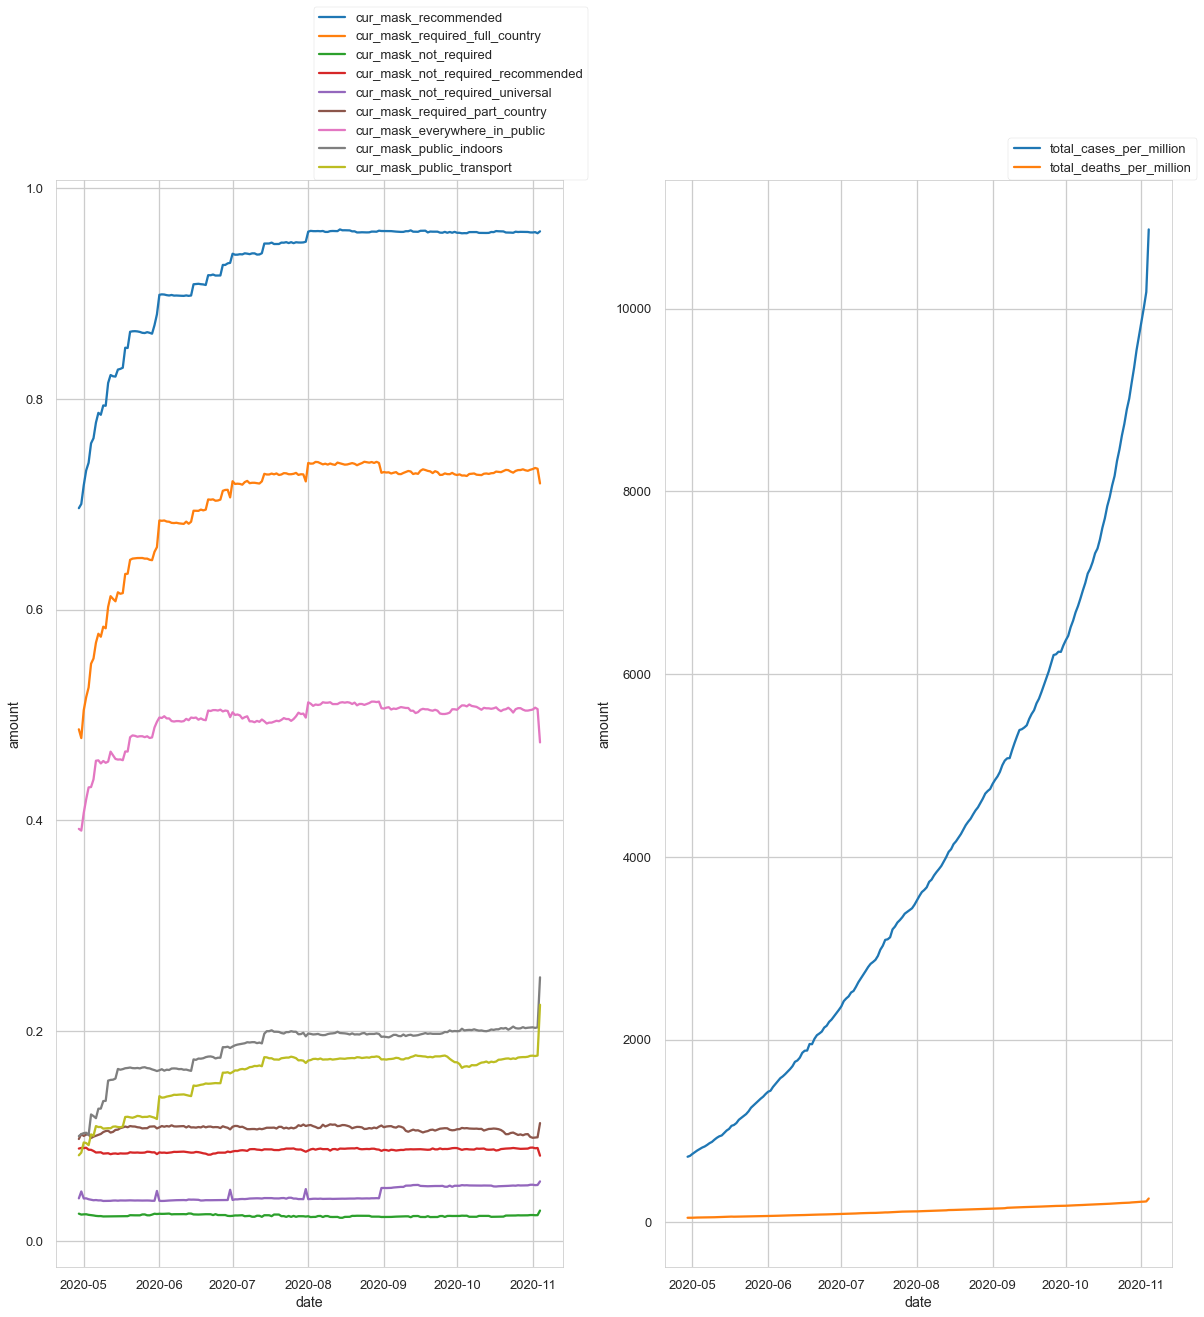

In [40]:
f, axes = plt.subplots(1,2, figsize=(20,20))

g12 = sns.lineplot(data=df_masks_req_time, x='date', y='amount', hue='data_requirements', ax=axes[0]);
g12.legend().set_title('');
g12.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);

g13 = sns.lineplot(data=df_total_cases, x='date', y='amount', hue='data_cases', ax=axes[1]);
g13.legend().set_title('');
g13.legend(bbox_to_anchor=(1.05, 1),loc=4, borderaxespad=0.);